# perform inference using oscillations of random amplitude and frequency


In [1]:
import numpy as np
import os, sys
import json

project_root = os.path.abspath("")  # alternative
if project_root[-12:] == 'LyoSavin2023':
    base_dir = project_root
else:
    base_dir = os.path.dirname(project_root)
sys.path.append(os.path.join(base_dir, 'core'))
sys.path.append(os.path.join(base_dir, 'core/utils'))

import torch
import torch.optim as optim
import time
from tqdm.auto import tqdm
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42  # makes fonts editable in Adobe Illustrator
matplotlib.rcParams['ps.fonttype'] = 42
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm, trange

from utils import remove_all_ticks_and_labels

2023-11-22 17:01:10.381879: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-22 17:01:10.424190: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## first vary the frequency of the oscillation

we want to maintain the sinusoidal shape, only varying the frequency

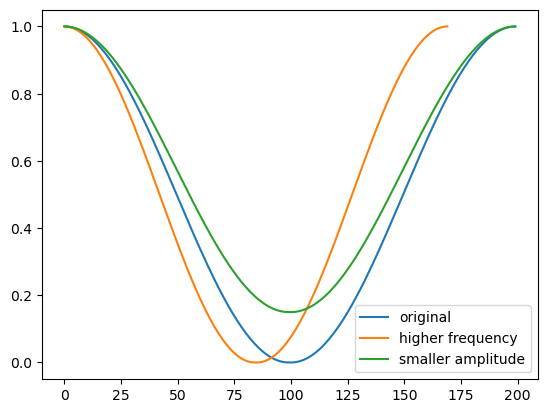

In [2]:
# show the different beta schedules
from utils import make_beta_schedule, convert_beta_l_to_beta_t, convert_beta_t_to_beta_l

n_timesteps = 100

betas = make_beta_schedule('sine', n_timesteps=n_timesteps)

def make_beta_t_schedule(n_timesteps=100, n_periods=1):
    betas = make_beta_schedule(schedule='sine', n_timesteps=n_timesteps)
    betas_one_period = torch.cat([betas, reversed(betas)])
    beta_t_one_period = convert_beta_l_to_beta_t(betas_one_period, betas)
    beta_t = torch.cat([beta_t_one_period for _ in range(n_periods)])
    return beta_t

# original beta schedule
b = make_beta_t_schedule(n_timesteps=100, n_periods=1)

# higher frequency beta schedule
b_higher_freq = make_beta_t_schedule(n_timesteps=85, n_periods=1)

# smaller amplitude beta schedule
def make_beta_schedule_different_amplitude(amplitude, betas):
    b_l_different_amp_min = convert_beta_t_to_beta_l(1-amplitude, betas)
    betas_different_amp = make_beta_schedule('sine', n_timesteps, end=b_l_different_amp_min)
    b_different_amp = convert_beta_l_to_beta_t(torch.cat([betas_different_amp, reversed(betas_different_amp)]), betas)
    return b_different_amp

b_smaller_amp = make_beta_schedule_different_amplitude(.85, betas)

# b_l_smaller_amp_max = convert_beta_t_to_beta_l(1.2, betas)
# print(b_l_smaller_amp_max)
# betas_smaller_amp = make_beta_schedule('sine', n_timesteps, start=b_l_smaller_amp_max)
# b_smaller_amp = convert_beta_l_to_beta_t(torch.cat([betas_smaller_amp, reversed(betas_smaller_amp)]), betas)

fig, ax = plt.subplots(1, 1)
ax.plot(b, label='original')
ax.plot(b_higher_freq, label='higher frequency')
ax.plot(b_smaller_amp, label='smaller amplitude')
ax.legend()

torch.Size([1858])


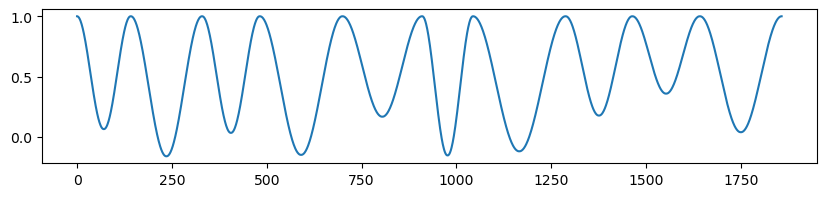

In [3]:
# now make the period and amplitude random variables
n_periods = 10
periods = torch.normal(1, .15, size=(n_periods,))
amplitudes = torch.normal(1, .15, size=(n_periods,))

def make_random_beta_oscillations(betas, n_periods=1, periods=[100], amplitudes=[1]):
    beta_multiple_periods = []
    periods = (periods*100).to(torch.int64)
    for i in range(int(n_periods)):
        period = periods[i]
        amplitude = amplitudes[i]
        b_l_different_amp_min = convert_beta_t_to_beta_l(1-amplitude, betas)
        beta_ls = make_beta_schedule('sine', period, end=b_l_different_amp_min)
        beta_ts = convert_beta_l_to_beta_t(torch.cat([beta_ls, reversed(beta_ls)]), betas)
        beta_multiple_periods.append(beta_ts)
    beta_multiple_periods = torch.cat(beta_multiple_periods)
    return beta_multiple_periods

betas_multiple_periods = make_random_beta_oscillations(betas, n_periods=10, periods=periods, amplitudes=amplitudes)
print(betas_multiple_periods.shape)

fig, ax = plt.subplots(1, 1, figsize=(10, 2))
ax.plot(betas_multiple_periods)

In [4]:
from prior_utils import p_rev_loop, p_sample_loop

global device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

def get_coefficients(num_steps, device, schedule='sigmoid', start=1e-5, end=2e-2):
    '''calculate the forward process for the given noise schedule'''
    from utils import make_beta_schedule
    betas = make_beta_schedule(schedule=schedule, n_timesteps=num_steps, start=start, end=end, device=device)
    alphas = 1 - betas
    alphas_prod = torch.cumprod(alphas, 0)
    one_minus_alphas_prod_sqrt = torch.sqrt(1 - alphas_prod)
    return betas, alphas, one_minus_alphas_prod_sqrt

@torch.no_grad()
def p_sample(model, x, t, n_steps, alphas, betas, one_minus_alphas_prod_sqrt, device):
    """
    returns one step of the neural forward process. takes a noisy data sample x_{t-1} and returns a more noisy x_t.
    """
    from utils import extract
    t = torch.tensor([t], device=device)
    T = t.repeat(x.shape[0], 1)
    # Factor to the model output
    eps_factor = ((1 - extract(alphas, t, x)) / extract(one_minus_alphas_prod_sqrt, t, x))
    # Model output
    eps_theta = model(x, T)
    # Final values
    mean = (1 / extract(alphas, t, x).sqrt()) * (x - (eps_factor * eps_theta))
    # Generate z
    z = torch.randn_like(x, device=device)
    # Fixed sigma
    sigma_t = extract(betas, t, x).sqrt()
    sample = mean + sigma_t * z
    return sample

# ------- alternating between the neural forward and reverse processes ------- #
def perform_one_cycle(init_x, model, num_steps, coefficients, schedule='sine'):
    '''
    undergoes one cycle of the oscillation.
    diffuses the datapoints using the neural forward process, and then anti-diffuses using the neural reverse process.
    '''
    betas, alphas, one_minus_alphas_prod_sqrt = coefficients
    
    if type(init_x) == np.ndarray:
        init_x = torch.tensor(init_x, dtype=torch.float)
    else: 
        init_x = init_x
    
    # neural forward process
    cur_x = init_x
    for i in range(num_steps):
        cur_x = p_sample(model, cur_x, i, num_steps, alphas, betas, one_minus_alphas_prod_sqrt, device)
    
    # neural reverse process
    for i in reversed(range(num_steps)):
        cur_x = p_sample(model, cur_x, i, num_steps, alphas,betas,one_minus_alphas_prod_sqrt, device)
    return cur_x


def neural_sampling_custom_betas(model, init_x, num_cycles, betas, period=1, amplitude=1, disable_tqdm=False, schedule='sine'):
    # customize beta schedule
    from utils import convert_beta_t_to_beta_l
    import numbers
    
    num_cycles = int(num_cycles)
    
    if isinstance(period, numbers.Number) and isinstance(amplitude, numbers.Number):
        # both period and amplitude are scalars
        num_steps = int(100*period)
        b_l_different_amp_min = convert_beta_t_to_beta_l(1-amplitude, betas)
        coefficients = get_coefficients(num_steps, device, schedule, end=b_l_different_amp_min)
    elif isinstance(period, (list, torch.Tensor, np.ndarray)) and isinstance(amplitude, (list, torch.Tensor, np.ndarray)):
        # both period and amplitude are lists
        num_steps_per_cycle = (100*period).to(torch.int64)
        b_l_different_amp_min = convert_beta_t_to_beta_l(1-amplitude, betas)
        coeff_per_cycle = []
        for i in range(num_cycles):
            coeff = get_coefficients(num_steps_per_cycle[i], device, schedule, end=b_l_different_amp_min[i])
            coeff_per_cycle.append(coeff)
    else:
        raise ValueError('period and amplitude must both be scalars or lists/array/tensors')
    
    if type(init_x) == np.ndarray:
        init_x = torch.tensor(init_x, dtype=torch.float)
    else: 
        init_x = init_x
    
    # burn the first sample
    coefficients = get_coefficients(100, device, schedule)
    x = perform_one_cycle(init_x, model, 100, coefficients, schedule)
    
    seq_x = []    
    for i in tqdm(range(num_cycles), disable=disable_tqdm):
        if not isinstance(period, numbers.Number) and not isinstance(amplitude, numbers.Number):
            coefficients = coeff_per_cycle[i]
            num_steps = num_steps_per_cycle[i]
        x = perform_one_cycle(x, model, num_steps, coefficients, schedule)
        seq_x.append(x)
    seq_x = torch.stack(seq_x).detach().cpu().numpy().reshape(num_cycles, -1)
    return seq_x

def repeat_scalar(scalar, repeats):
    return torch.tensor(scalar).tile(int(repeats))
    

Using device: cuda


In [5]:
# model
from utils import select_model, make_beta_schedule
model, num_steps, embedding_dims = select_model('unconditional-dendritic-4-layers', 1)
model.to(device)

# dataset
from dataset_utils import generate_2d_swiss_roll
dataset = generate_2d_swiss_roll(int(1e3), True, True)[1]

# sample a random datapoint from the dataset
init_x = dataset[np.random.randint(0, len(dataset))].reshape(-1, 2).to(device)
original_betas = make_beta_schedule('sine', n_timesteps=n_timesteps)

model loaded!


# original beta

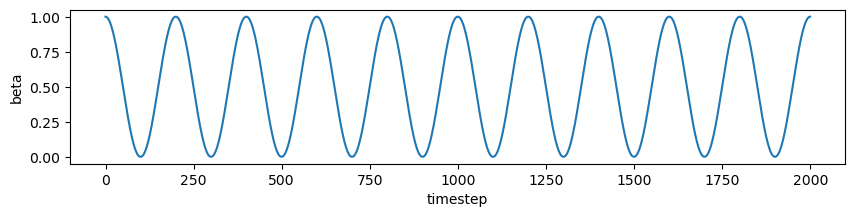

In [85]:
# draw samples using the normal beta oscillations
num_samples = 10
period = 1
amplitude = 1

periods = repeat_scalar(period, num_samples)
amplitudes = repeat_scalar(amplitude, num_samples)
betas_multiple_periods = make_random_beta_oscillations(betas, num_samples, periods, amplitudes)

fig, ax = plt.subplots(1, 1, figsize=(10, 2))
ax.plot(betas_multiple_periods)
ax.set(xlabel='timestep', ylabel='beta')

# save plot
fig.savefig(os.path.join(base_dir, 'core', 'plots', 'random_waves', 'original_beta.pdf'), dpi=300, bbox_inches='tight')

  0%|          | 0/10 [00:00<?, ?it/s]

<AxesSubplot: >

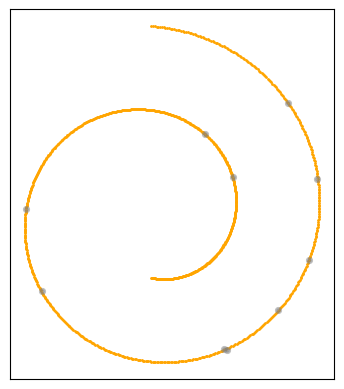

In [7]:
num_samples = 10
period = 1
amplitude = 1
periods = repeat_scalar(period, num_samples)
amplitudes = repeat_scalar(amplitude, num_samples)
x_seq_original = neural_sampling_custom_betas(model, init_x, num_samples, original_betas, period, amplitude)

fig, ax = plt.subplots(1, 1)
ax.scatter(dataset[:, 0], dataset[:, 1], s=1, c='orange')
ax.scatter(*x_seq_original.T, s=10, alpha=0.5, lw=2, c='grey')
ax.set(aspect='equal')
remove_all_ticks_and_labels(ax)

# only period is a random variable

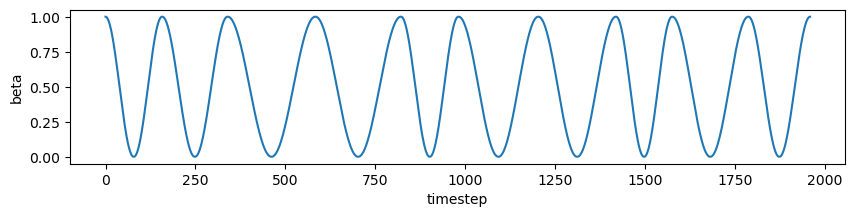

In [87]:
num_samples = 10
periods = torch.normal(1, .15, size=(int(num_samples),))
amplitude = 1
amplitudes = repeat_scalar(amplitude, num_samples)
betas_multiple_periods = make_random_beta_oscillations(betas, num_samples, periods, amplitudes)

fig, ax = plt.subplots(1, 1, figsize=(10, 2))
ax.plot(betas_multiple_periods)
ax.set(xlabel='timestep', ylabel='beta')

# save plot
fig.savefig(os.path.join(base_dir, 'core', 'plots', 'random_waves', 'random_periods.pdf'), dpi=300, bbox_inches='tight')

  0%|          | 0/10 [00:00<?, ?it/s]

<AxesSubplot: >

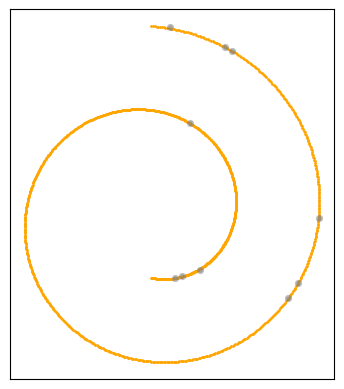

In [10]:
num_samples = 10
periods = torch.normal(1, .15, size=(int(num_samples),))
amplitude = 1
amplitudes = repeat_scalar(amplitude, num_samples)
x_seq_random_period = neural_sampling_custom_betas(model, init_x, num_samples, original_betas, periods, amplitudes)

fig, ax = plt.subplots(1, 1)
ax.scatter(dataset[:, 0], dataset[:, 1], s=1, c='orange')
ax.scatter(*x_seq_random_period.T, s=10, alpha=0.5, lw=2, c='grey')
ax.set(aspect='equal')
remove_all_ticks_and_labels(ax)

In [11]:
# calculate KL divergence between the ground truth data and the generated data
from likelihood_utils import calculate_histogram
num_bins_per_dim = 15
domain_range = 2

from dataset_utils import generate_2d_swiss_roll
dataset = generate_2d_swiss_roll(int(2e3), True, True)[1]

histogram_dataset = calculate_histogram(dataset, num_bins_per_dim, domain_range)
histogram_period_samples = calculate_histogram(x_seq_random_period, num_bins_per_dim, domain_range)

# calculate the KL divergence by comparing histograms
from scipy.stats import entropy
epsilon = 1e-5

# ------------------------------------ iid ----------------------------------- #
p = histogram_period_samples + epsilon  # distribution of model generated samples 
q = histogram_dataset + epsilon  # distribution to compare against

p = p.flatten() / np.sum(p)  # turn into a vector and then normalize
q = q.flatten() / np.sum(q)  # turn into a vector and then normalize
kl_div = entropy(p, q)
print(kl_div)

1.475972006164969


# only amplitude is a random variable

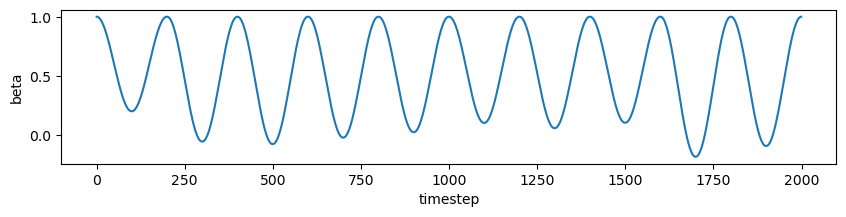

In [88]:
num_samples = 10
period = 1
periods = repeat_scalar(period, num_samples)
amplitudes = torch.normal(1, .15, size=(int(num_samples),))
betas_multiple_periods = make_random_beta_oscillations(betas, num_samples, periods, amplitudes)

fig, ax = plt.subplots(1, 1, figsize=(10, 2))
ax.plot(betas_multiple_periods)
ax.set(xlabel='timestep', ylabel='beta')

# save plot
fig.savefig(os.path.join(base_dir, 'core', 'plots', 'random_waves', 'random_amplitudes.pdf'), dpi=300, bbox_inches='tight')

  0%|          | 0/10 [00:00<?, ?it/s]

<AxesSubplot: >

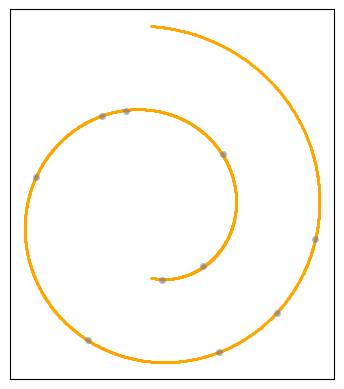

In [53]:
num_samples = 10
period = 1
periods = repeat_scalar(period, num_samples)
# amplitudes = torch.normal(1, .15, size=(int(num_samples),))
x_seq_random_amplitude = neural_sampling_custom_betas(model, init_x, num_samples, original_betas, periods, amplitudes)

fig, ax = plt.subplots(1, 1)
ax.scatter(dataset[:, 0], dataset[:, 1], s=1, c='orange')
ax.scatter(*x_seq_random_amplitude.T, s=10, alpha=0.5, lw=2, c='grey')
ax.set(aspect='equal')
remove_all_ticks_and_labels(ax)

In [14]:
# calculate KL divergence between the ground truth data and the generated data
from likelihood_utils import calculate_histogram
num_bins_per_dim = 15
domain_range = 2

from dataset_utils import generate_2d_swiss_roll
dataset = generate_2d_swiss_roll(int(2e3), True, True)[1]

histogram_dataset = calculate_histogram(dataset, num_bins_per_dim, domain_range)
histogram_amplitude_samples = calculate_histogram(x_seq_random_amplitude, num_bins_per_dim, domain_range)

# calculate the KL divergence by comparing histograms
from scipy.stats import entropy
epsilon = 1e-5

# ------------------------------------ iid ----------------------------------- #
p = histogram_amplitude_samples + epsilon  # distribution of model generated samples 
q = histogram_dataset + epsilon  # distribution to compare against

p = p.flatten() / np.sum(p)  # turn into a vector and then normalize
q = q.flatten() / np.sum(q)  # turn into a vector and then normalize
kl_div = entropy(p, q)
print(kl_div)

1.1926680474815252


# both period and amplitude are random variables

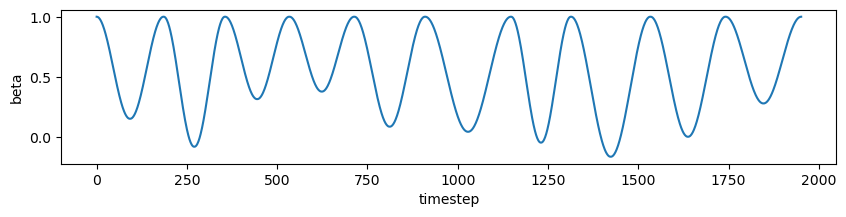

In [90]:
num_samples = 10
periods = torch.normal(1, .15, size=(int(num_samples),))
amplitudes = torch.normal(1, .15, size=(int(num_samples),))

betas_multiple_periods = make_random_beta_oscillations(betas, num_samples, periods, amplitudes)

fig, ax = plt.subplots(1, 1, figsize=(10, 2))
ax.plot(betas_multiple_periods)
ax.set(xlabel='timestep', ylabel='beta')

# save plot
fig.savefig(os.path.join(base_dir, 'core', 'plots', 'random_waves', 'both_random.pdf'), dpi=300, bbox_inches='tight')

  0%|          | 0/10 [00:00<?, ?it/s]

<AxesSubplot: >

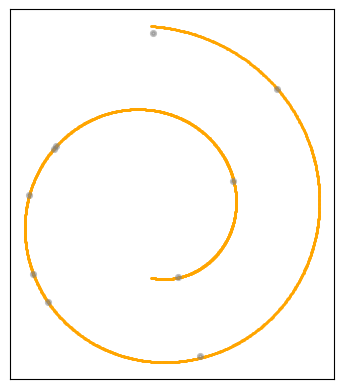

In [16]:
num_samples = 10
periods = torch.normal(1, .15, size=(int(num_samples),))
amplitudes = torch.normal(1, .15, size=(int(num_samples),))
x_seq_random_both = neural_sampling_custom_betas(model, init_x, num_samples, original_betas, periods, amplitudes)

fig, ax = plt.subplots(1, 1)
ax.scatter(dataset[:, 0], dataset[:, 1], s=1, c='orange')
ax.scatter(*x_seq_random_both.T, s=10, alpha=0.5, lw=2, c='grey')
ax.set(aspect='equal')
remove_all_ticks_and_labels(ax)

In [17]:
# calculate KL divergence between the ground truth data and the generated data
from likelihood_utils import calculate_histogram
num_bins_per_dim = 15
domain_range = 2

from dataset_utils import generate_2d_swiss_roll
dataset = generate_2d_swiss_roll(int(2e3), True, True)[1]

histogram_dataset = calculate_histogram(dataset, num_bins_per_dim, domain_range)
histogram_both_samples = calculate_histogram(x_seq_random_both, num_bins_per_dim, domain_range)

# calculate the KL divergence by comparing histograms
from scipy.stats import entropy
epsilon = 1e-5

# ------------------------------------ iid ----------------------------------- #
p = histogram_both_samples + epsilon  # distribution of model generated samples 
q = histogram_dataset + epsilon  # distribution to compare against

p = p.flatten() / np.sum(p)  # turn into a vector and then normalize
q = q.flatten() / np.sum(q)  # turn into a vector and then normalize
kl_div = entropy(p, q)
print(kl_div)

1.385151470360686


# measuring KL for various periods and amplitudes

now let's do the above but for periods and amplitudes of different variances


In [6]:
# now let's do the above but for periods and amplitudes of different variances

# dataset
from dataset_utils import generate_2d_swiss_roll
dataset = generate_2d_swiss_roll(int(2e3), True, True)[1]

# sample a random datapoint from the dataset
original_betas = make_beta_schedule('sine', n_timesteps=n_timesteps)


num_samples = 2e3
list_of_values = [0, .05, .1, .15, .2, .25, .3]
deterministic_value = repeat_scalar(1, num_samples)

x_seq_random_periods, x_seq_random_amplitudes, x_seq_random_boths = {}, {}, {}
for v in tqdm(list_of_values):
    init_x = dataset[np.random.randint(0, len(dataset))].reshape(-1, 2).to(device)

    periods = torch.normal(1, v, size=(int(num_samples),))
    amplitudes = torch.normal(1, v, size=(int(num_samples),))

    x_seq_random_periods[v] = neural_sampling_custom_betas(model, init_x, num_samples, original_betas, periods, deterministic_value, disable_tqdm=True)
    x_seq_random_amplitudes[v] = neural_sampling_custom_betas(model, init_x, num_samples, original_betas, deterministic_value, amplitudes, disable_tqdm=True)
    x_seq_random_boths[v] = neural_sampling_custom_betas(model, init_x, num_samples, original_betas, periods, amplitudes, disable_tqdm=True)

print(x_seq_random_periods.keys())

  0%|          | 0/7 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [7]:
mode = 'load'
# save the numpy arrays
save_dir = os.path.join(base_dir, 'core', 'saved_arrays', 'random_waves')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

if mode=='save':
    np.save(os.path.join(save_dir, 'x_seq_random_periods.npy'), x_seq_random_periods)
    np.save(os.path.join(save_dir, 'x_seq_random_amplitudes.npy'), x_seq_random_amplitudes)
    np.save(os.path.join(save_dir, 'x_seq_random_boths.npy'), x_seq_random_boths)
elif mode=='load':
    x_seq_random_periods = np.load(os.path.join(save_dir, 'x_seq_random_periods.npy'), allow_pickle=True).item()
    x_seq_random_amplitudes = np.load(os.path.join(save_dir, 'x_seq_random_amplitudes.npy'), allow_pickle=True).item()
    x_seq_random_boths = np.load(os.path.join(save_dir, 'x_seq_random_boths.npy'), allow_pickle=True).item()


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/ceph/users/blyo1/projects/LyoSavin2023/core/saved_arrays/random_waves/x_seq_random_periods.npy'

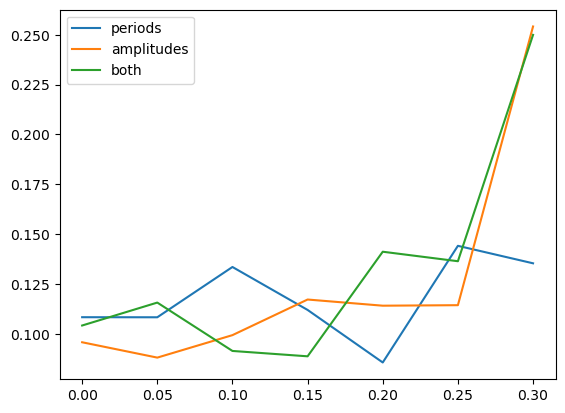

In [13]:
# KL divergence 
from likelihood_utils import calculate_histogram
num_bins_per_dim = 15
domain_range = 2
# calculate the KL divergence by comparing histograms
from scipy.stats import entropy
epsilon = 1e-5

from dataset_utils import generate_2d_swiss_roll
dataset = generate_2d_swiss_roll(int(2e3), True, True)[1]

histogram_dataset = calculate_histogram(dataset, num_bins_per_dim, domain_range)

list_of_values = [0, .05, .1, .15, .2, .25, .3]

kl_div_periods, kl_div_amplitudes, kl_div_boths = [], [], []
for idx, l in enumerate(list_of_values): 
    histogram_period_samples = calculate_histogram(x_seq_random_periods[l], num_bins_per_dim, domain_range)

    # ------------------------------------ iid ----------------------------------- #
    p = histogram_period_samples + epsilon  # distribution of model generated samples 
    q = histogram_dataset + epsilon  # distribution to compare against

    p = p.flatten() / np.sum(p)  # turn into a vector and then normalize
    q = q.flatten() / np.sum(q)  # turn into a vector and then normalize
    kl_div_periods.append(entropy(p, q))
    
for idx, l in enumerate(list_of_values):
    histogram_amplitude_samples = calculate_histogram(x_seq_random_amplitudes[l], num_bins_per_dim, domain_range)
    
    # ------------------------------------ iid ----------------------------------- #
    p = histogram_amplitude_samples + epsilon  # distribution of model generated samples 
    q = histogram_dataset + epsilon  # distribution to compare against

    p = p.flatten() / np.sum(p)  # turn into a vector and then normalize
    q = q.flatten() / np.sum(q)  # turn into a vector and then normalize
    kl_div_amplitudes.append(entropy(p, q))
    
for idx, l in enumerate(list_of_values):
    histogram_both_samples = calculate_histogram(x_seq_random_boths[l], num_bins_per_dim, domain_range)
    
    # ------------------------------------ iid ----------------------------------- #
    p = histogram_both_samples + epsilon  # distribution of model generated samples 
    q = histogram_dataset + epsilon  # distribution to compare against

    p = p.flatten() / np.sum(p)  # turn into a vector and then normalize
    q = q.flatten() / np.sum(q)  # turn into a vector and then normalize
    kl_div_boths.append(entropy(p, q))
    
fig, ax = plt.subplots(1, 1)
ax.plot(list_of_values, kl_div_periods, label='periods')
ax.plot(list_of_values, kl_div_amplitudes, label='amplitudes')
ax.plot(list_of_values, kl_div_boths, label='both')
ax.legend()

## multiple iterations of the above

In [77]:
# save the numpy arrays
load_dir = os.path.join(base_dir, 'core', 'saved_arrays', 'random_waves')
list_of_variances = [0, .05, .1, .15, .2]

from likelihood_utils import calculate_histogram
from dataset_utils import generate_2d_swiss_roll
from analysis_utils import calculate_KL_divergence

num_bins_per_dim = 14
domain_range = 1.5
dataset = generate_2d_swiss_roll(int(2e3), True, False)[1]
histogram_dataset = calculate_histogram(dataset, num_bins_per_dim, domain_range)

epsilon = 1e-5

kl_periods, kl_amplitudes, kl_boths = {}, {}, {}
for v in list_of_variances:
    kl_periods_one_v, kl_amplitudes_one_v, kl_both_one_v = [], [], []
    for iter_idx in range(20):
        x_random_period = np.load(os.path.join(load_dir, f'x_seq_random_period-variance={v}-v{iter_idx}.npy'), allow_pickle=True)
        x_random_amplitude = np.load(os.path.join(load_dir, f'x_seq_random_amplitude-variance={v}-v{iter_idx}.npy'), allow_pickle=True)
        x_random_both = np.load(os.path.join(load_dir, f'x_seq_random_both-variance={v}-v{iter_idx}.npy'), allow_pickle=True)
        
        # histograms
        histogram_period = calculate_histogram(x_random_period, num_bins_per_dim, domain_range)
        histogram_amplitude = calculate_histogram(x_random_amplitude, num_bins_per_dim, domain_range)
        histogram_both = calculate_histogram(x_random_both, num_bins_per_dim, domain_range)
        
        # kl divergence
        kl_period = calculate_KL_divergence(histogram_period, histogram_dataset, epsilon)
        kl_amplitude = calculate_KL_divergence(histogram_amplitude, histogram_dataset, epsilon)
        kl_both = calculate_KL_divergence(histogram_both, histogram_dataset, epsilon)
        
        # append
        kl_periods_one_v.append(kl_period)
        kl_amplitudes_one_v.append(kl_amplitude)
        kl_both_one_v.append(kl_both)
        
    kl_periods[v] = kl_periods_one_v
    kl_amplitudes[v] = kl_amplitudes_one_v
    kl_boths[v] = kl_both_one_v


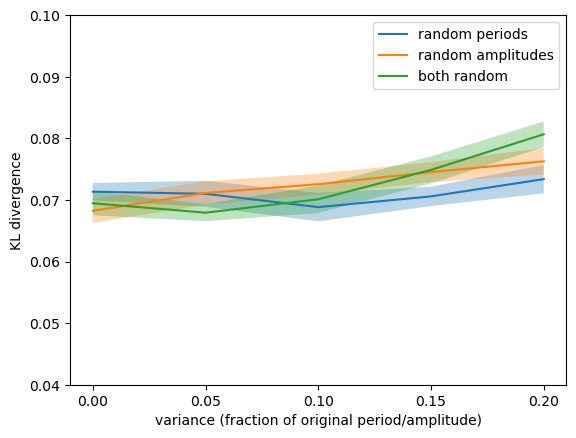

In [84]:
kl_period_means = np.array([np.mean(kl_periods[v]) for v in list_of_variances])
kl_amplitude_means = np.array([np.mean(kl_amplitudes[v]) for v in list_of_variances])
kl_both_means = np.array([np.mean(kl_boths[v]) for v in list_of_variances])

kl_period_sems = np.array([np.std(kl_periods[v])/len(list_of_variances) for v in list_of_variances])
kl_amplitude_sems = np.array([np.std(kl_amplitudes[v])/len(list_of_variances) for v in list_of_variances])
kl_both_sems = np.array([np.std(kl_boths[v])/len(list_of_variances) for v in list_of_variances])
    
fig, ax = plt.subplots(1, 1)
ax.plot(list_of_variances, kl_period_means, label='random periods')
ax.plot(list_of_variances, kl_amplitude_means, label='random amplitudes')
ax.plot(list_of_variances, kl_both_means, label='both random')

ax.fill_between(list_of_variances, kl_period_means-kl_period_sems, kl_period_means+kl_period_sems, alpha=.3)
ax.fill_between(list_of_variances, kl_amplitude_means-kl_amplitude_sems, kl_amplitude_means+kl_amplitude_sems, alpha=.3)
ax.fill_between(list_of_variances, kl_both_means-kl_both_sems, kl_both_means+kl_both_sems, alpha=.3)

ax.legend()
ax.set(xlabel='variance (fraction of original period/amplitude)', ylabel='KL divergence')
# ax.set(ylim=[0.05, 0.15])
ax.set(ylim=[0.04, 0.1])
ax.set(xticks=list_of_variances)

# save figure
fig.savefig(os.path.join(base_dir, 'core', 'plots', 'random_waves', 'kl_divergence.pdf'), dpi=300, bbox_inches='tight')